In [37]:
import requests
from requests import get
import os
import unicodedata
import re
import json

import acquire as a
import prepare as p

import pandas as pd # to handle the dataframe
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Acquire and Prepare functions with train, validate and test
df = a.get_data(query_url = False)
print(df.shape)
df = p.prepare_dataframe(df)
train, validate, test = p.split_data(df)
train.shape, validate.shape, test.shape

Found file in working directory!
(70932, 83)


((53199, 63), (26599, 63), (26600, 63))

In [3]:
train.head()

,id,name,lang,released_at,layout,highres_image,image_status,mana_cost,cmc,type_line,...,hand_modifier,content_warning,flavor_name,usd,usd_foil,eur,eur_foil,is_foil,is_etched,is_glossy
12661,2d911053-a026-4b20-ba2d-dbcc367c1413,Ajani Goldmane,en,2010-07-16,normal,True,highres_scan,{2}{W}{W},4.0,Legendary Planeswalker — Ajani,...,0.0,False,no_flavor,8.02,15.11,8.02,15.11,True,False,False
61300,dcb2e0d6-3181-4d3d-a3b4-3896288b2e0e,Champion of Lambholt,en,2020-08-07,normal,True,highres_scan,{1}{G}{G},3.0,Creature — Human Warrior,...,0.0,False,no_flavor,0.36,3.22,0.36,3.22,True,False,False
48604,af3aa149-00fa-4932-b004-f64c8b5d3ca7,Gargoyle,en,2009-07-17,token,True,highres_scan,,0.0,Token Artifact Creature — Gargoyle,...,0.0,False,no_flavor,0.25,0.00,0.25,0.00,False,False,False
55734,c8d75604-4941-4faf-8f1a-7fc529e64962,Goblin Settler,en,2022-04-12,normal,True,highres_scan,{3}{R},4.0,Creature — Goblin,...,0.0,False,no_flavor,9.76,11.87,9.76,11.87,True,False,False
70638,feef03a1-f19a-413b-ad86-0b357cf9c09c,Weight Advantage,en,2016-08-26,normal,True,highres_scan,,0.0,Conspiracy,...,0.0,False,no_flavor,0.11,0.42,0.11,0.42,True,False,False


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53199 entries, 12661 to 1677
Data columns (total 63 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                53199 non-null  object        
 1   name              53199 non-null  object        
 2   lang              53199 non-null  object        
 3   released_at       53199 non-null  datetime64[ns]
 4   layout            53199 non-null  object        
 5   highres_image     53199 non-null  bool          
 6   image_status      53199 non-null  object        
 7   mana_cost         53199 non-null  object        
 8   cmc               53194 non-null  float64       
 9   type_line         53194 non-null  object        
 10  oracle_text       53199 non-null  object        
 11  power             53199 non-null  object        
 12  toughness         53199 non-null  object        
 13  colors            53199 non-null  object        
 14  color_identity    5

# Hypothesis 1
- H0:The amount of cards created is not = to the artist value.
- HA:The amount of cards created is not = to the artist value.

In [38]:
# Rarity card count
df.rarity.value_counts()

common      25755
rare        22792
uncommon    17468
mythic       4659
special       248
bonus          10
Name: rarity, dtype: int64

In [6]:
train['usd'].value_counts()

0.00       12933
0.10        1611
0.09        1301
0.08        1173
0.05        1150
           ...  
28.61          1
1787.50        1
29.78          1
44.23          1
55.99          1
Name: usd, Length: 2895, dtype: int64

<AxesSubplot:>

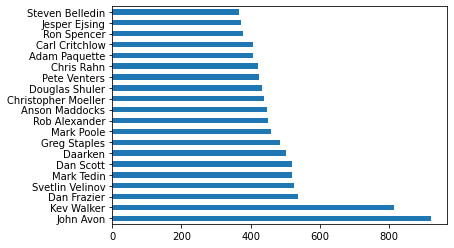

In [7]:
# Top 20 artist who created the most cards
train['artist'].value_counts()[:20].plot(kind='barh')

<AxesSubplot:>

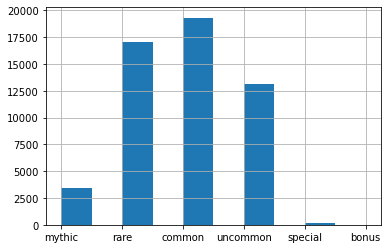

In [8]:
# Count of cards by rarity
train.rarity.hist()

In [9]:
# filter out lands and tokens 

train = train.loc[train['rarity'].isin(['common', 'uncommon', 'rare', 
                                        'mythic', 'special', 'bonus'])]
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53199 entries, 12661 to 1677
Columns: 63 entries, id to is_glossy
dtypes: bool(17), datetime64[ns](1), float64(9), object(36)
memory usage: 19.9+ MB


This gives 53199 cards.

In [10]:
# show only data from the selected columns
df2 = train[['name', 'set_type', 'artist', 'rarity', 'usd', 'usd_foil', 'foil']]


In [11]:
# show only data from top 40 cards by price
df3 = df2.loc[:,'name':'foil'].sort_values(by=['usd'], ascending=False,)[:100]

In [12]:
df3

,name,set_type,artist,rarity,usd,usd_foil,foil
49832,Black Lotus,core,Christopher Rush,rare,11500.00,0.0,False
12737,Ancestral Recall,core,Mark Poole,rare,6999.99,0.0,False
47092,Tropical Island,core,Jesper Myrfors,rare,6000.00,0.0,False
497,Timetwister,core,Mark Tedin,rare,5732.99,0.0,False
9371,Mox Ruby,core,Dan Frazier,rare,5499.99,0.0,False
...,...,...,...,...,...,...,...
31738,Nicol Bolas,expansion,"Edward P. Beard, Jr.",rare,455.99,0.0,False
41337,City in a Bottle,expansion,Drew Tucker,rare,454.40,0.0,False
68584,Plateau,core,Cornelius Brudi,rare,450.68,0.0,False
58486,Icy Manipulator,core,Douglas Shuler,uncommon,449.99,0.0,False


In [13]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 49832 to 10115
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      100 non-null    object 
 1   set_type  100 non-null    object 
 2   artist    100 non-null    object 
 3   rarity    100 non-null    object 
 4   usd       100 non-null    float64
 5   usd_foil  100 non-null    float64
 6   foil      100 non-null    bool   
dtypes: bool(1), float64(2), object(4)
memory usage: 5.6+ KB


### Visualization

Used the top 100 cards based on value to chart results.

<AxesSubplot:>

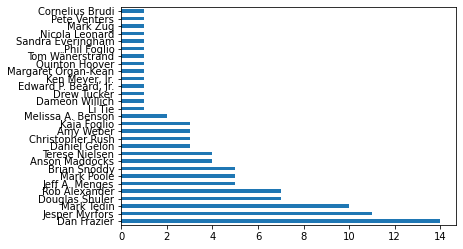

In [14]:
# Plot top 100 cards and artist by amount of cards created
df3['artist'].value_counts().plot(kind='barh')

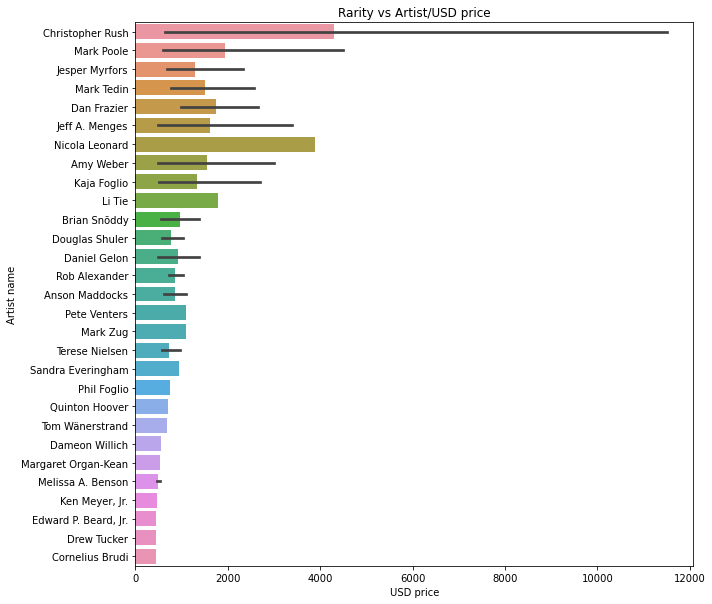

In [15]:
# Bar plor to show Artist and USD price, for top artist
def vis_artist_by_usd(df3):
    plt.figure(figsize=(10,10))
    sns.barplot(data=df3, x='usd', y='artist')
    plt.title('Rarity vs Artist/USD price')
    plt.xlabel('USD price')
    plt.ylabel('Artist name')
    plt.show()

vis_artist_by_usd(df3)


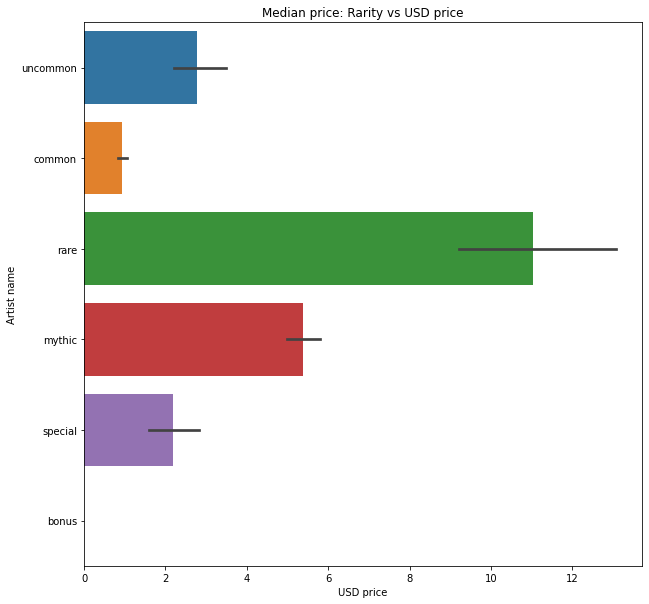

In [32]:
# Median price for all cards based on Rarity and USD price
def vis_rarity_by_usd(df):
    plt.figure(figsize=(10,10))
    sns.barplot(data=df, x='usd', y='rarity')
    plt.title('Median price: Rarity vs USD price')
    plt.xlabel('USD price')
    plt.ylabel('Artist name')
    plt.show()

vis_rarity_by_usd(df)


In [33]:
df.rarity.value_counts()


common      25755
rare        22792
uncommon    17468
mythic       4659
special       248
bonus          10
Name: rarity, dtype: int64

### Key takeaway

- The amount of cards created is not = to the artist value.

- In the charts artist Jon Avon created the most cards but the artist Christopher Rush created the most expensive card(Black Lotus)



# Hypothesis 2
- H0: artist and rarity of cards is = to price 
- HA: artist and rarity of cards is not = to price

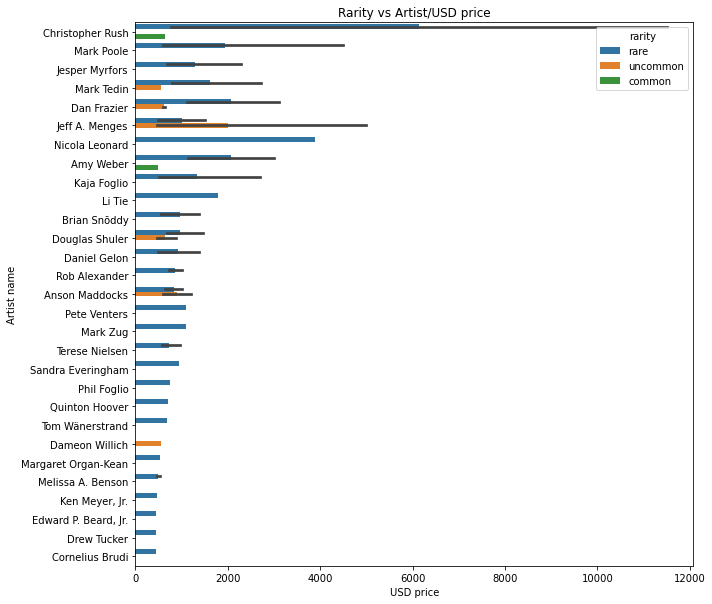

In [34]:
# Bar plot to show Artist, USD price and rarity of cards for top artist
def vis_artist_by_usd(df3):
    plt.figure(figsize=(10,10))
    sns.barplot(data=df3, x='usd', y='artist', hue='rarity')
    plt.title('Rarity vs Artist/USD price')
    plt.xlabel('USD price')
    plt.ylabel('Artist name')
    plt.show()

vis_artist_by_usd(df3)

### Key takeaway

- The artist and rarity of cards is not = to price

- In the charts only one none rare card is in the high value price range.


# Hypothesis 3
- H0: set_type and rarity of cards is = to price 
- HA: set_type and rarity of cards is not = to price

In [17]:
# Cards value count to set_types
df.set_type.value_counts()

expansion           22466
masters              8233
core                 7840
promo                7481
commander            5671
draft_innovation     4552
memorabilia          3204
box                  3090
duel_deck            1945
token                1613
starter              1115
funny                 971
planechase            647
alchemy               536
treasure_chest        431
masterpiece           373
archenemy             326
from_the_vault        157
vanguard              117
premium_deck          105
arsenal                35
spellbook              24
Name: set_type, dtype: int64

<AxesSubplot:xlabel='count', ylabel='set_type'>

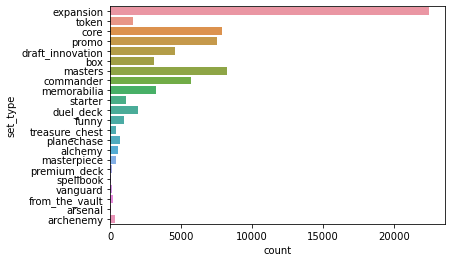

In [18]:
# Most expensive cards by set_type
sns.countplot(data= df, y='set_type')

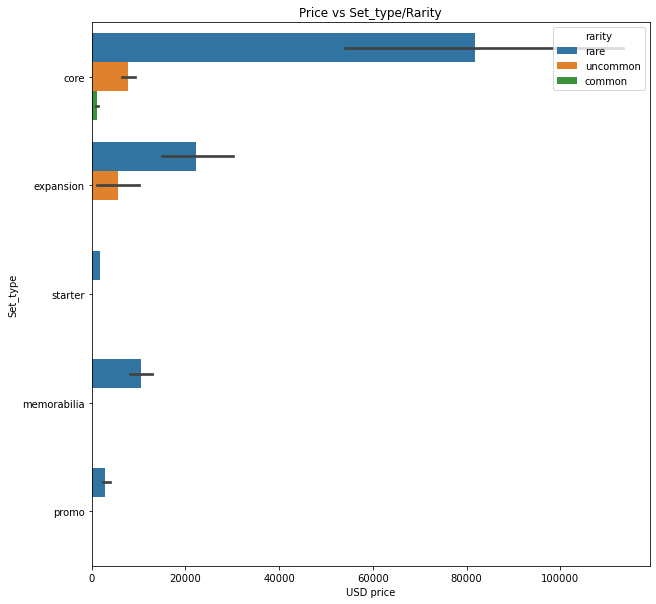

In [35]:
# top 100 cards: Set_type and Rarity 
def usd_rarity_set_type_total(df3):
    plt.figure(figsize=(10,10))
    sns.barplot(data=df3, x='usd', y='set_type', hue='rarity', estimator=sum)
    plt.title('Price vs Set_type/Rarity')
    plt.xlabel('USD price')
    plt.ylabel('Set_type')
    plt.show()

usd_rarity_set_type_total(df3)

### Key takeaway

- Rare cards are the most expensive regardless of set_type

- In the charts there are only a few none rare cards in the top 100 high value price range.

